In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/kaiweizhang/Documents/GitHub/Econ_IO_24Fall/assignment2')

global MARKET_DATA, CONSUMER


In [2]:
from pandarallel import pandarallel
# Setup MRE
pandarallel.initialize(progress_bar=False, verbose=0)

# 1

## 1(a): Compute $\bar{y}_t, \sigma_{y_t}$, and $\bar{p}_t$ for each market. Compute $\operatorname{cor}\left(\bar{y}_t, \bar{p}_t\right)$. Do consumers in wealthier markets buy more expensive products on average?

ans1_df is a df that for each market, the row tells the average income, variance of income, and average price paid on this market. Since mean_y and avg_p has positive correlation, we guess wealthier people buy more expensive products.


In [3]:
census_data = pd.read_csv('consumer_census.csv')
# groupby t, get the mean and variance of income. Do that for me
income_mean_variance_df = census_data.groupby('t')['income'].agg(['mean', 'var'])
#income_mean_variance_df.loc[1:3]
ans1_df = income_mean_variance_df
ans1_df.columns=['mean_y', 'var_y']

MARKET_DATA = pd.read_csv('product_data_ps2.csv')
MARKET_DATA['weighted_price']= MARKET_DATA['price']*MARKET_DATA['market_share']
ans1_df['avg_p'] = MARKET_DATA.groupby('t')['weighted_price'].agg(['sum'])
# drop weighted_price in market_data
market_data = MARKET_DATA.drop(columns=['weighted_price'])
ans1_df[:4]

,mean_y,var_y,avg_p
t,,,
1,6.002591,0.266339,2.059838
2,4.550203,0.236291,2.173610
3,5.929497,0.233196,2.335994
4,4.432515,0.241526,2.047550


In [4]:
# calculate correlation between avg_p and mean_y on ans1_df
ans1_df['mean_y'].corr(ans1_df['avg_p'])

0.15430274953743148

## 1(b) Draw Consumer Data
draw_consumer is a function that takes a true distribution (pd.Series), sample size and random seed number that returns a df with S consumers, each has income, nu1 and nu2.

for the first bullet point I just use the whole data and replicate for 50 times. For the second, I use market-t data for each t.

ans is a summary for the first fake data, statistics looks as what we want

CONSUMER is what we get for second.

In [5]:
def draw_consumer(true_distribution, S, SEED):
    '''S for sample size, SEED for random seed, true_distribution for the distribution of income'''
    np.random.seed(SEED)
    income_distribution = np.random.choice(true_distribution, size=S, replace=True)

    nu1 = np.random.normal(0,1,S)
    nu2 = np.random.normal(0,1,S)
    fake_consumer_sample = pd.DataFrame({'income': income_distribution,'nu_1':nu1, 'nu_2':nu2})
    return fake_consumer_sample

dic ={}
for i in range(1,51):
    df= draw_consumer(census_data['income'].values, 100, SEED = i)
    dic[i] = [df['income'].var(),df['income'].mean(), df['nu_1'].var(), df['nu_1'].mean(), df['nu_2'].var(), df['nu_2'].mean()]

ans = pd.DataFrame(dic).T
ans.columns = ['income_var', 'income_mean', 'nu1_var', 'nu1_mean', 'nu2_var', 'nu2_mean']

ans[:2]

,income_var,income_mean,nu1_var,nu1_mean,nu2_var,nu2_mean
1,0.535060,5.131497,0.819948,0.194297,0.939500,0.092831
2,0.486349,5.303420,1.163719,-0.101821,0.855095,0.028442


In [6]:
# 500 for each t, concat to the same dataframe CONSUMER
# For each t, input t-market consumer data for true distribution.
CONSUMER = pd.DataFrame()
for i in range(1,51):
    temp_source = census_data[census_data['t']==i]
    df= draw_consumer(temp_source['income'].values, 500, SEED = i)
    df['t'] = i
    CONSUMER = pd.concat([CONSUMER, df])
CONSUMER=CONSUMER.reset_index(drop=True)
CONSUMER

,income,nu_1,nu_2,t
0,5.989803,1.942579,-0.827635,1
1,5.200218,0.057218,0.036102,1
2,6.145651,-2.123898,0.920336,1
3,5.320450,-0.658673,-1.471675,1
4,6.454278,-0.829596,-0.595459,1
...,...,...,...,...
24995,6.009967,1.222179,0.207061,50
24996,6.876404,-0.813060,0.348388,50
24997,5.722658,0.108086,0.057580,50
24998,6.501130,-1.077602,-0.597333,50


## 1(c) Estimate share equation
calculate_s is a function with inputs delta, theta, t (which market delta is for?), it also takes market_data and consumer, in case I need

return is a new df. it's consumer data  with the right t, plus 50 new columns: P_i for probability of choose i.

In [7]:
delta_guess = [1]*50
theta = [0.5,1,1]

def calculate_s(delta_guess,theta, Temp_T=1, market_data=MARKET_DATA, CONSUMER=CONSUMER):
    """
    Given delta_guess and theta, calculate s(prob that i choose j) for each consumer 
    Seems input is only for Temp_T, I need Temp_T to pin down the market data
    return: CONSUMER.query(t), with 50 new columns which tells the probability of choosing each product
    """
    delta_input =np.array([0]+list(delta_guess))

    [alpha, sigma1,sigma2] =theta

    data1=market_data[['product_ID','price','sugar','caffeine','t']]
    # generate a table with price_1,price_2,..price_10 for each t

    temp_data=data1[data1['t']== Temp_T].drop(columns=['t'])
    temp_CONSUMER = CONSUMER[CONSUMER['t']== Temp_T]
    temp_data # data on t=1 market


    p_row = temp_data[['price']].T #50x1 for 50 ID
    sug_row = temp_data[['sugar']].T
    caf_row = temp_data[['caffeine']].T
    table1=pd.concat([p_row,sug_row,caf_row],axis=0)
    table1

    table2=temp_CONSUMER[['income','nu_1','nu_2']]
    table2['income']=table2['income']*alpha
    table2['nu_1']=table2['nu_1']*sigma1
    table2['nu_2']=table2['nu_2']*sigma2
    table2.shape, table1.shape #calculate table1*table2 in matrix
    m1=np.array(table1)
    m2=np.array(table2)
    m = m2@m1
    m.shape  # now I want CONSUMER add m as a new column
    mu_lis=[]

    for i in range(1,51):
        temp_CONSUMER['mu_'+ str(i)] = m[:,i-1]
        mu_lis.append('mu_'+ str(i))
    temp_CONSUMER

    sum_lis = []
    for i in range(1,51):
        temp_CONSUMER['exp_delta_plus_mu'+str(i)] = np.exp(temp_CONSUMER['mu_'+str(i)]+delta_input[i])
        sum_lis.append('exp_delta_plus_mu'+str(i))
    temp_CONSUMER['new'] = temp_CONSUMER[sum_lis].sum(axis=1)+1 #sum_k(exp(delta_k+mu_k))+1
    temp_CONSUMER['new'] = np.log(temp_CONSUMER['new'])

    P_lis=[]
    for i in range(1,51):
        temp_CONSUMER['P_'+str(i)] = temp_CONSUMER['mu_'+str(i)]+delta_input[i]-temp_CONSUMER['new']
        temp_CONSUMER['P_'+str(i)]=np.exp(temp_CONSUMER['P_'+str(i)])
        P_lis.append('P_'+str(i))
    temp_CONSUMER[P_lis].sum(axis=1) # sum to around 1, good

    # drop mu_lis and sum_lis
    temp_CONSUMER=temp_CONSUMER.drop(columns=mu_lis)
    temp_CONSUMER=temp_CONSUMER.drop(columns=sum_lis)
    temp_CONSUMER = temp_CONSUMER.drop(columns='new')


    return temp_CONSUMER

In [8]:
example = calculate_s(delta_guess,theta,1)
example

,income,nu_1,nu_2,t,P_1,P_2,P_3,P_4,P_5,P_6,...,P_41,P_42,P_43,P_44,P_45,P_46,P_47,P_48,P_49,P_50
0,5.989803,1.942579,-0.827635,1,6.073427e-07,0.000018,8.380787e-07,0.000005,5.446349e-07,7.010009e-08,...,0.000729,0.000018,0.000224,0.319837,0.018147,5.470483e-01,0.001091,0.001703,0.001379,0.000109
1,5.200218,0.057218,0.036102,1,1.013956e-02,0.009615,3.755242e-03,0.003091,2.536672e-03,8.126946e-03,...,0.009727,0.011023,0.006236,0.076368,0.083956,6.042140e-02,0.031015,0.029672,0.010334,0.005170
2,6.145651,-2.123898,0.920336,1,5.492064e-02,0.001047,3.708724e-03,0.000268,2.454607e-03,3.418783e-01,...,0.000016,0.001379,0.000021,0.000002,0.000071,7.047303e-07,0.000155,0.000084,0.000009,0.000031
3,5.320450,-0.658673,-1.471675,1,8.638413e-03,0.009856,2.301226e-02,0.018811,4.190085e-02,2.376076e-03,...,0.011441,0.009001,0.014135,0.006662,0.006789,1.501865e-02,0.005455,0.005254,0.014783,0.020089
4,6.454278,-0.829596,-0.595459,1,4.239300e-02,0.018069,2.654947e-02,0.012042,2.883152e-02,2.869650e-02,...,0.007560,0.019324,0.007591,0.008105,0.018931,8.992706e-03,0.013432,0.011224,0.007858,0.009373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,6.091482,0.503981,-0.916539,1,6.297539e-04,0.002436,7.912867e-04,0.001429,7.601067e-04,1.493507e-04,...,0.011075,0.002486,0.006675,0.177103,0.060005,2.840998e-01,0.013571,0.015684,0.016073,0.005503
496,5.491843,0.631076,0.958863,1,1.669080e-03,0.001708,1.761151e-04,0.000162,6.118283e-05,2.347351e-03,...,0.001963,0.002274,0.000769,0.118095,0.115447,4.907536e-02,0.021879,0.021383,0.001908,0.000432
497,4.917683,0.041172,-0.381643,1,8.628376e-03,0.011296,5.997584e-03,0.005908,5.213905e-03,4.703529e-03,...,0.015891,0.012080,0.011523,0.082006,0.069285,8.925673e-02,0.028377,0.028376,0.018418,0.010494
498,5.330904,1.096270,0.570285,1,2.198272e-04,0.000609,4.369448e-05,0.000074,1.696372e-05,1.640559e-04,...,0.002031,0.000764,0.000710,0.257363,0.106770,1.494295e-01,0.014005,0.015794,0.002359,0.000366


## 1(d) Compute $S_{i,j,t}$
I define a function generate_total_df which takes $\bar\alpha,\beta_1,\beta_2,\gamma$ and $\theta=(\alpha^y,\sigma_1,\sigma_2)$. Also it's allowed to change market_data.

The return is a CONSUMER data with 50 more prob columns. 

Basically, this is a mapping from $\lambda=(\bar\alpha,\beta_1,\beta_2,\gamma)$ and $\theta=(\alpha^y,\sigma_1,\sigma_2)$, to $s_{i,j,t} (\lambda,\theta)$. Can also write it as $S_{i,j,t} (\delta,\theta)$ since $\delta$ is function of $\lambda$.

df1 and df2 are two df with $\theta,\theta'$, each column is a consumer, with 50 probabilitys. Haven't compare them yet

In [9]:
def generate_total_df(bar_alpha,beta_1,beta_2,gamma,theta, market_data=MARKET_DATA):
    """here theta is 3x1 array for alpha^y,sigma1,sigma2"""
    temp_df  = market_data[['price','sugar','caffeine','product_ID','t']]
    temp_df['delta'] = temp_df['price']*bar_alpha+temp_df['sugar']*beta_1+temp_df['caffeine']*beta_2+gamma
    total_df=pd.DataFrame()
    for Temp_T in range(1,51):
        small_df = temp_df[temp_df['t']==Temp_T]
        delta_guess = small_df['delta'].values
        temp_CONSUMER = calculate_s(delta_guess,theta,Temp_T)
        total_df = pd.concat([total_df,temp_CONSUMER])
    return total_df

In [10]:
bar_alpha = -1
beta_1=0.5
beta_2=0.5
gamma=-1.5
df1 = generate_total_df(bar_alpha,beta_1,beta_2,gamma,theta=[0,0,0])
df2 = generate_total_df(bar_alpha,beta_1,beta_2,gamma,theta=[0,1,1])
df2

,income,nu_1,nu_2,t,P_1,P_2,P_3,P_4,P_5,P_6,...,P_41,P_42,P_43,P_44,P_45,P_46,P_47,P_48,P_49,P_50
0,5.989803,1.942579,-0.827635,1,9.436943e-07,0.000045,0.000003,0.000036,0.000002,1.886541e-07,...,2.862511e-03,4.113562e-05,1.178048e-03,2.947806e-01,0.009828,5.045083e-01,0.001505,2.687935e-03,0.004904,0.000557
1,5.200218,0.057218,0.036102,1,9.904330e-03,0.014984,0.007324,0.010580,0.005475,1.328932e-02,...,2.346622e-02,1.550156e-02,1.887936e-02,5.771773e-02,0.038110,4.424282e-02,0.031092,3.376203e-02,0.022756,0.014860
2,6.145651,-2.123898,0.920336,1,4.339233e-02,0.001346,0.006955,0.000921,0.005437,4.709954e-01,...,3.162823e-05,1.561976e-03,5.670190e-05,9.577150e-07,0.000019,3.155956e-07,0.000106,6.544236e-05,0.000016,0.000082
3,5.320450,-0.658673,-1.471675,1,6.215120e-05,0.000113,0.000338,0.000487,0.000687,2.876710e-05,...,2.040301e-04,9.318454e-05,3.193525e-04,3.561442e-05,0.000022,7.817217e-05,0.000039,4.312662e-05,0.000240,0.000432
4,6.454278,-0.829596,-0.595459,1,7.022806e-03,0.004900,0.011045,0.009298,0.014472,8.400217e-03,...,3.211152e-03,4.582149e-03,4.467353e-03,6.811818e-04,0.000923,7.707308e-04,0.001814,1.742342e-03,0.003005,0.005443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,6.009967,1.222179,0.207061,50,7.038226e-05,0.000057,0.000137,0.000484,0.000016,2.172159e-05,...,8.805149e-02,2.544350e-02,2.047667e-02,1.564477e-03,0.041760,1.159164e-03,0.001237,2.677961e-01,0.000637,0.001004
24996,6.876404,-0.813060,0.348388,50,8.598768e-03,0.024444,0.015153,0.012411,0.044572,9.971950e-03,...,4.240198e-03,3.921668e-03,2.486480e-03,9.926166e-03,0.009126,1.163843e-02,0.005006,5.111936e-04,0.004359,0.006762
24997,5.722658,0.108086,0.057580,50,5.531700e-03,0.006506,0.008496,0.012564,0.005615,3.954219e-03,...,5.565820e-02,3.661656e-02,3.076857e-02,1.848271e-02,0.055208,1.540202e-02,0.014488,5.136161e-02,0.010696,0.013476
24998,6.501130,-1.077602,-0.597333,50,6.438270e-03,0.005731,0.005180,0.002588,0.020200,1.447483e-02,...,1.194460e-04,2.831781e-04,3.641973e-04,1.566299e-03,0.000213,1.104210e-03,0.002045,1.086989e-04,0.002594,0.001609


## 1(e): estimate market share
Now fix any t, given $\delta,\theta$, predict_share_from_delta_theta tells the expected market share $\hat s_{jt}(\delta,\theta)$ for 50 brands, where the return is a 50-len pd.Series, index P_i. 

If you want a mapping from $\delta,\theta$ to share, just call predict_share_from_delta_theta. I use this function for later contraction mapping. 

Under the guessed theta, we get the correlation between market-average income and market-average price is 0.05, which is lower than the data.  So seems we under estimate bar_alpha.

In [11]:
global P_lis
P_lis=[]
for i in range(1,51):
    P_lis.append('P_'+str(i))

#focus on 1 market
def predict_share_from_delta_theta(delta_guess,theta, Temp_T=1, market_data = MARKET_DATA, consumer=CONSUMER):
    temp_consumer_data = calculate_s(delta_guess,theta, Temp_T,market_data, consumer)
    ans = temp_consumer_data[P_lis].sum()/len(temp_consumer_data)
    return ans

#focus on all market
def predict_share_from_nonlinear_theta(bar_alpha,beta_1,beta_2,gamma,theta, market_data = MARKET_DATA, consumer=CONSUMER): 
    total_df = generate_total_df(bar_alpha,beta_1,beta_2,gamma,theta,market_data)
    ans = total_df[P_lis].sum()/len(total_df)
    return ans


dic_predict_share = predict_share_from_nonlinear_theta(bar_alpha,beta_1,beta_2,gamma,[0,0,0])

dic_predict_share = predict_share_from_delta_theta(delta_guess,[0,0,0])

print(dic_predict_share[:2])

P_1    0.019854
P_2    0.019854
dtype: float64


In [12]:
total_df = generate_total_df(bar_alpha,beta_1,beta_2,gamma,theta,market_data)

by_t = total_df.groupby('t')[P_lis].sum()/500
by_t=by_t.reset_index()

# write a function, for market_data.apply, each column let get t and j= product_ID
def get_P_j_from_market_data(row):
    # write a function, take t, j, return (t,'P_j') element in by_t
    def get_P_j(t,j):
        t=int(t)
        j=int(j)
        return by_t[by_t['t']==t]['P_'+str(j)].values[0]
    return get_P_j(row['t'],row['product_ID'])

market_data['predict_share'] = market_data.apply(get_P_j_from_market_data,axis=1)
market_data

,product_ID,price,sugar,caffeine,corn_syrup_price,caffeine_extract_price,quantity,t,market_share,predict_share
0,1,2.021334,1.580856,6.074459,0.199022,0.264899,223,1,0.0223,0.011589
1,2,1.980251,3.033151,5.260598,0.199022,0.264899,39,1,0.0039,0.004070
2,3,1.655560,1.718876,4.685728,0.199022,0.264899,83,1,0.0083,0.003175
3,4,1.566470,2.637858,4.250370,0.199022,0.264899,16,1,0.0016,0.001863
4,5,1.517629,1.476214,4.137802,0.199022,0.264899,141,1,0.0141,0.002944
...,...,...,...,...,...,...,...,...,...,...
2495,46,2.368628,3.699026,5.598460,0.210564,0.255062,252,50,0.0252,0.007312
2496,47,1.719465,4.031755,3.961574,0.210564,0.255062,12,50,0.0012,0.002072
2497,48,2.529186,7.770437,3.606250,0.210564,0.255062,1158,50,0.1158,0.115593
2498,49,1.674552,3.751779,3.642175,0.210564,0.255062,30,50,0.0030,0.002143


In [13]:
market_data['new']=market_data['price']*market_data['predict_share']
p_double_prime = market_data.groupby('t')['new'].sum()/50

y_bar = census_data.groupby('t')['income'].mean()

# calculate correlation between avg_p and mean_y on ans1_df
p_double_prime.corr(y_bar)
# In true data it's 0.15, here it's 0.05 so seems we under estimate bar_alpha.

0.19001487629480673

In [14]:
global delta_guess

# 2

## 2(a) Solve $\delta(\theta)$ by contraction mapping

In [15]:
# return abs norm
def calc_diff(a):
    loss = 0
    for i in list(a):
        loss+=abs(i)
    return loss

# if tol =1e-4, use 8.8s, if 1e-8 use 16s, seems no big change
def solve_delta_from_theta(theta, t, market_data = MARKET_DATA, consumer=CONSUMER, tol=1e-4):
    """Given theta and t, start from delta_guess, update delta_t(theta) until converge"""
    global delta_guess
    delta_late = delta_guess
    diff = 1000
    while diff>tol:
        s_hat = list(predict_share_from_delta_theta(delta_late,theta, Temp_T=t,market_data=market_data,consumer=consumer))
        real_s = list(market_data[market_data['t']==t]['market_share'])
        delta_new = delta_late + np.log(real_s)-np.log(s_hat)
        diff = calc_diff(delta_new-delta_late)
        delta_late = delta_new
    return delta_late


In [16]:
solve_delta_from_theta(theta,t=1)[:2]

array([-3.500381  , -4.10675815])

## 2(b)
fix t=1 and THETA=[0,1,1], repeat for 100 rounds, in each round, draw a new consumer data with 100 sample on market t=1, and get delta(THETA). Sum for analysis

### 2(b).0, generate delta for each round

In [17]:
# NEVER RUN AGAIN
# global TEMP_T,THETA, TOTAL_ROUND
# TEMP_T =1
# TOTAL_ROUND= 100
# THETA = [0,1,1]

# def draw_consumer(true_distribution, S, SEED):
#     np.random.seed(SEED)
#     income_distribution = np.random.choice(true_distribution, size=S, replace=True)

#     nu1 = np.random.normal(0,1,S)
#     nu2 = np.random.normal(0,1,S)
#     fake_consumer_sample = pd.DataFrame({'income': income_distribution,'nu_1':nu1, 'nu_2':nu2})
    
#     return fake_consumer_sample

# dic ={}
# for round in range(TOTAL_ROUND): 
#     # For each round draw a consumer data, with seed round+100000 so won't replicate CONSUMER
#     temp_consumer_data = draw_consumer(census_data['income'].values, 100, SEED = 100000+round)
#     temp_consumer_data['t'] = TEMP_T
#     temp_delta = solve_delta_from_theta(THETA, TEMP_T, market_data = MARKET_DATA, consumer=temp_consumer_data)
#     dic[round] = temp_delta

# # ans is actually 100 rounds of delta, each column is one round, with 50 delta, each brand on t=1 market
# ans = pd.DataFrame(dic).T
# ans.to_pickle('ans2.pkl')


### 2(b).1, density of delta_1

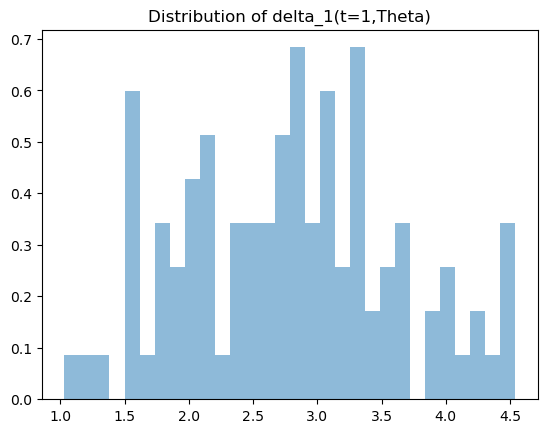

In [18]:
ans=pd.read_pickle('ans2.pkl')
plt.hist(ans[0],bins=30, alpha=0.5, label='delta_1(t=1,Theta)', density=True)
plt.title('Distribution of delta_1(t=1,Theta)')
plt.show()

### 2(b).2, 2(b).3, sample mean and variance

In [19]:
sample_mean = ans[0].mean()
sample_var = ans[0].var()
sample_mean, sample_var

(2.792906416824737, 0.6962454618290845)

### 2(b).4 Try sample =500 repeat

In [20]:
# # NEVER RUN AGAIN
# dic ={}
# for round in range(TOTAL_ROUND): 
#     # For each round draw a consumer data, with seed round+100000 so won't replicate CONSUMER
#     temp_consumer_data = draw_consumer(census_data['income'].values, 500, SEED = 200000+round)
#     temp_consumer_data['t'] = TEMP_T
#     temp_delta = solve_delta_from_theta(THETA, TEMP_T, market_data = MARKET_DATA, consumer=temp_consumer_data)
#     dic[round] = temp_delta

# # ans is actually 100 rounds of delta, each column is one round, with 50 delta, each brand on t=1 market
# ans = pd.DataFrame(dic).T
# ans.to_pickle('ans2_500.pkl')

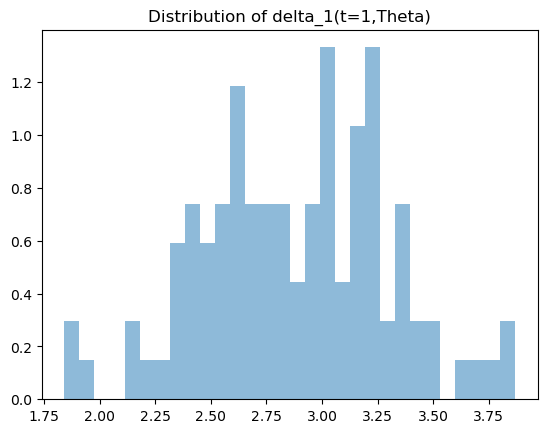

In [21]:
ans=pd.read_pickle('ans2_500.pkl')
plt.hist(ans[0],bins=30, alpha=0.5, label='delta_1(t=1,Theta)', density=True)
plt.title('Distribution of delta_1(t=1,Theta)')
plt.show()

In [22]:
sample_mean = ans[0].mean()
sample_var = ans[0].var()
sample_mean, sample_var

(2.879128070100644, 0.17899809136960249)

# 3 Wrap up the estimation

## 3(a) IV function construction
I generate predict price, predict price times avg income, and $\sum_{k}(caff_{kt}-caff_{it})^2$ and so for sugar, save in before Z matrix, without saving t and product ID indexes

Z matrix will stack before_Z_matrix

In [23]:
market_data = MARKET_DATA.copy()

market_data['IV_syrup'] = market_data['sugar']*market_data['corn_syrup_price']
market_data['IV_coffee'] = market_data['caffeine']*market_data['caffeine_extract_price']

from statsmodels.regression.linear_model import OLS
Y = market_data['price']
X = sm.add_constant(market_data[['sugar','caffeine','IV_syrup','IV_coffee']])
model = OLS(Y, X).fit()
model.summary()

market_data['predict_price'] = model.predict(X)  # predict_price is \hat p
market_data[['price','predict_price']].corr()

mean_y_df = ans1_df[['mean_y']].reset_index()

market_data = market_data.merge(mean_y_df, left_on='t', right_on='t')
market_data['predict_price_income'] = market_data['predict_price']*market_data['mean_y'] # predict_price_income is \hat p * y_bar
# for j != product ID, calculate sum (caf_jt-caf_it)^2
def get_caf_diff(row):
    t = row['t']
    j = row['product_ID']
    caf_jt = row['caffeine']
    caf_it = market_data[market_data['t']==t]['caffeine'].values
    return sum((caf_jt-caf_it)**2)


def get_sugar_diff(row):
    t = row['t']
    j = row['product_ID']
    sugar_jt = row['sugar']
    sugar_it = market_data[market_data['t']==t]['sugar'].values
    return sum((sugar_jt-sugar_it)**2)

market_data['caf_diff'] = market_data.apply(get_caf_diff,axis=1) # \sum_k(caf_k-caf_i)^2
market_data['sugar_diff'] = market_data.apply(get_sugar_diff,axis=1) # \sum_k(sug_k-sug_i)^2

before_Z_matrix  = market_data[['predict_price_income','predict_price','sugar_diff','caf_diff','sugar','caffeine']]
before_Z_matrix['constant'] =1
# re-order for match
before_Z_matrix = before_Z_matrix[['constant','sugar','caffeine','predict_price','predict_price_income','caf_diff','sugar_diff']]

## 3(b). Calculate Loss function given $\tilde\theta_2$

In [24]:
from scipy.linalg import inv
def calc_theta_1(X,Z,W,delta_vector):
    left = X.T@Z@W@Z.T@X
    right = X.T@Z@W@Z.T@delta_vector
    return inv(left)@right

In [25]:

Z =np.array(before_Z_matrix)

W = inv(Z.T@ Z/2500)
print(W.shape)

before_X_matrix = market_data[['price','sugar','caffeine']]
before_X_matrix['constant'] = 1
X=np.array(before_X_matrix)


(7, 7)


In [26]:
THETA = [-0.5, 2, 2] #This is theta_2


def calc_loss_q_value(THETA):
    '''
    This is a large map given theta_2, return delta(theta_2) [2500*1], q_value [1*1] and g_1_vector [7*1]
    for each T I get a delta_t(theta_2) then concatenate them to get delta_vector
    '''
    jobs = pd.DataFrame()
    jobs['t'] = range(1,51)
    jobs['theta'] = [THETA]*50

    def get_delta(row):
        return solve_delta_from_theta(row['theta'],t=row['t'])


    jobs['delta']=jobs.parallel_apply(get_delta,axis=1)  

    delta_long = []
    for i in list(jobs['delta']):
        delta_long+=list(i)
    #print(len(delta_long))

    delta_vector = np.array(delta_long)
    theta_1 = calc_theta_1(X,Z,W,delta_vector)
    theta_1

    [alpha_bar_hat, beta_1_bar_hat, beta_2_bar_hat, gamma_hat] = theta_1
    
    # estimate xi hat(theta_2)
    P = MARKET_DATA['price']
    Sugar = MARKET_DATA['sugar']
    Caffeine = MARKET_DATA['caffeine']
    Xi = delta_vector-alpha_bar_hat*P-beta_1_bar_hat*Sugar-beta_2_bar_hat*Caffeine-gamma_hat

    g_1_vector = Z.T@Xi/2500
    q_value = g_1_vector.T@W@g_1_vector
    return [delta_long, q_value, g_1_vector]

#jobs['delta']=jobs.apply(get_delta,axis=1)  
# a for-loop takes around 15min=14.6s*50
# apply takes 12min
# parallel_apply takes 2min good

[delta_long, q_value, g_1_vector] = calc_loss_q_value(THETA)
print(q_value)

0.8599533165604321


In [27]:
global DELTA_for_THETA, DELTA_dict
import copy
DELTA_for_THETA = copy.deepcopy(delta_long)

DELTA_dict = {}
for i in range(50):
    DELTA_dict[i+1] = DELTA_for_THETA[i*50:(i+1)*50]
# This is the delta of THETA (given theta_2=[-0.5,2,2]), can use it to check delta_t = DELTA_dict[t]

## 3(c). Compute analytic gradient

Given 
$$
\hat{s}_{j t}\left(\delta_t, \theta_2\right) \approx \sum_{i \in \mathcal{S}_t} w_{i t} s_{i j t}=\sum_{i \in \mathcal{S}_t} w_{i t} \frac{\exp \left(\delta_{j t}+\mu_{i j t}\left(\theta_2\right)\right)}{1+\sum_{k \in J_t} \exp \left(\delta_{k t}+\mu_{i k t}\left(\theta_2\right)\right)}
$$
We should have for $j\neq l$
$$
\partial \hat s_{jt}/\partial \delta_{lt} = -1*\sum_{i \in \mathcal{S}_t} w_{i t} \frac{\exp \left(\delta_{j t}+\mu_{i j t}\left(\theta_2\right)\right)}{1+\sum_{k \in J_t} \exp \left(\delta_{k t}+\mu_{i k t}\left(\theta_2\right)\right)}* \frac{\exp \left(\delta_{l t}+\mu_{i l t}\left(\theta_2\right)\right)}{1+\sum_{k \in J_t} \exp \left(\delta_{k t}+\mu_{i k t}\left(\theta_2\right)\right)} = (\sum_{i \in \mathcal{S}_t} -1*P_j*P_l)/500
$$

and if $j=l$ I need to add another term $P_j$


In [29]:
example = calculate_s(delta_guess,theta,1) # just an example, delta is function of theta

# input example is a consumer type data restricted on one market, with 50 columns of P_j, 
# return matrix dS/ddelta matrix only for period t. 
# t should be embeded in example: use t for correct example as input. 
def return_matrix_dshat_ddelta_period(example):
    expected_share=list(example[P_lis].sum()/len(example))  # then I get a 50*1 vector P_j

    # generate a 50*50 matrix, each is int -1* P_i*P_j dF(i)
    def calculate_dsj_ddeltak(i,j,example):
        example['new'] = example['P_'+str(i)]*example['P_'+str(j)]
        return -1* example['new'].sum()/len(example)

    matrix_dsj_ddeltak = np.zeros((50,50))
    for i in range(1,51):
        for j in range(1,51):
            matrix_dsj_ddeltak[i-1,j-1] = calculate_dsj_ddeltak(i,j,example)

    matrix_dsj_ddeltak.shape
    # self derivative has another element int P_i dF(i)=expected share
    another_matrix= np.zeros((50,50))
    for i in range(1,51):
        another_matrix[i-1,i-1] = expected_share[i-1]

    another_matrix

    matrix_dsj_ddeltak=matrix_dsj_ddeltak+another_matrix
    return matrix_dsj_ddeltak

# almost the same, just return sum_lis for calculations
# I use this function only for generate the ``example'' input for return_matrix_dshat_ddelta_period
def calculate_s_v2(delta_guess,theta, Temp_T=1, market_data=MARKET_DATA, CONSUMER=CONSUMER):
    """
    Given delta_guess and theta, calculate s(prob that i choose j) for each consumer 
    input is only for Temp_T, I need Temp_T to pin down the market data
    return: CONSUMER.query(t), with 50 new columns which tells the probability of choosing each product
    """
    delta_input =np.array([0]+list(delta_guess))

    [alpha, sigma1,sigma2] =theta

    data1=market_data[['product_ID','price','sugar','caffeine','t']]
    # generate a table with price_1,price_2,..price_10 for each t

    temp_data=data1[data1['t']== Temp_T].drop(columns=['t'])
    temp_CONSUMER = CONSUMER[CONSUMER['t']== Temp_T]
    temp_data # data on t=1 market


    p_row = temp_data[['price']].T #50x1 for 50 ID
    sug_row = temp_data[['sugar']].T
    caf_row = temp_data[['caffeine']].T
    table1=pd.concat([p_row,sug_row,caf_row],axis=0)
    table1

    table2=temp_CONSUMER[['income','nu_1','nu_2']]
    table2['income']=table2['income']*alpha
    table2['nu_1']=table2['nu_1']*sigma1
    table2['nu_2']=table2['nu_2']*sigma2
    table2.shape, table1.shape #calculate table1*table2 in matrix
    m1=np.array(table1)
    m2=np.array(table2)
    m = m2@m1
    m.shape  # now I want CONSUMER add m as a new column
    mu_lis=[]

    for i in range(1,51):
        temp_CONSUMER['mu_'+ str(i)] = m[:,i-1]
        mu_lis.append('mu_'+ str(i))
    temp_CONSUMER

    sum_lis = []
    for i in range(1,51):
        temp_CONSUMER['exp_delta_plus_mu'+str(i)] = np.exp(temp_CONSUMER['mu_'+str(i)]+delta_input[i])
        sum_lis.append('exp_delta_plus_mu'+str(i))
    temp_CONSUMER['new'] = temp_CONSUMER[sum_lis].sum(axis=1)+1 #sum_k(exp(delta_k+mu_k))+1
    temp_CONSUMER['new'] = np.log(temp_CONSUMER['new'])

    P_lis=[]
    for i in range(1,51):
        temp_CONSUMER['P_'+str(i)] = temp_CONSUMER['mu_'+str(i)]+delta_input[i]-temp_CONSUMER['new']
        temp_CONSUMER['P_'+str(i)]=np.exp(temp_CONSUMER['P_'+str(i)])
        P_lis.append('P_'+str(i))
    temp_CONSUMER[P_lis].sum(axis=1) # sum to around 1, good

    # drop mu_lis and sum_lis
    temp_CONSUMER=temp_CONSUMER.drop(columns=mu_lis)
    #temp_CONSUMER=temp_CONSUMER.drop(columns=sum_lis)
    temp_CONSUMER = temp_CONSUMER.drop(columns='new')


    return temp_CONSUMER



# This code is inefficient, but I don't use it so fine
# should not calc delta again:  check DELTA_dict
def generate_ds_ddelta_matrix(theta,t):
    delta_of_theta = solve_delta_from_theta(theta=theta,t=t)
    example = calculate_s(delta_of_theta, theta, t)
    return return_matrix_dshat_ddelta_period(example)

global sum_lis
sum_lis = []
for i in range(1,51):
    sum_lis.append('exp_delta_plus_mu'+str(i))

Then I calculate $\partial \hat s/\partial \theta_2 $ step by step

$$
\partial \hat s_{jt}/\partial \alpha = \sum_{i \in \mathcal{S}_t} \frac{1}{500} [ \frac{\exp \left(\delta_{j t}+\mu_{i j t}\left(\theta_2\right)\right)}{1+\sum_{k \in J_t} \exp \left(\delta_{k t}+\mu_{i k t}\left(\theta_2\right)\right)}*\frac{\partial \mu_{ijt}}{\partial \alpha}- \frac{\exp \left(\delta_{j t}+\mu_{i j t}\left(\theta_2\right)\right)}{1+\sum_{k \in J_t} \exp \left(\delta_{k t}+\mu_{i k t}\left(\theta_2\right)\right)}*\sum_k \frac{\exp \left(\delta_{k t}+\mu_{i k t}\left(\theta_2\right)\right)}{1+\sum_{k \in J_t} \exp \left(\delta_{k t}+\mu_{i k t}\left(\theta_2\right)\right)}*\frac{\partial \mu_{ikt}}{\partial \alpha}]
$$
Clearly I can let fix = income/nu_1/nu_2, and change for price/sug/caf

$\frac{\partial \mu_{ijt}}{\partial \alpha} = y_{it} p_{ijt}$

$\frac{\partial \mu_{ijt}}{\partial \sigma_1} = \nu_{1it} sug_{ijt}$

$\frac{\partial \mu_{ijt}}{\partial \alpha} = \nu_{2it} caf_{ijt}$

$$
\partial \hat s_{jt}/\partial \alpha = \sum_{i \in \mathcal{S}_t} \frac{1}{500} [ P_{ij} * y_{it} *p_{ijt} - P_{ij} *\sum_{k} P_{ik} * y_{it} *p_{ikt} ]
$$

In [30]:
# return a 50*3 matrix, ds_dtheta = [ds_dalpha, ds_dsigma1, ds_dsigma2]
def final_result_derive_theta(example, price_list, sug_list, caf_list, mode='alpha'):
    # if mode is alpha, then calculate derivative of use yit*priceit
    # if mode is sigma_1, then calculate derivative of use nu_1it*sugarit
    # if mode is sigma_2, then calculate derivative of use nu_2it*caffeineit
    exp_delta_lis = []
    exp_list=[]
    if mode == 'alpha':
        fix = 'income'
        change = 'price_'
    elif mode == 'sigma_1':
        fix = 'nu_1'
        change = 'sugar_'
    elif mode == 'sigma_2':
        fix = 'nu_2'    
        change = 'caffeine_'

    for i in range(1,51):
        example['price_'+str(i)] = price_list[i-1]
        example['sugar_'+str(i)] = sug_list[i-1]
        example['caffeine_'+str(i)] = caf_list[i-1]
        example['exp_delta_'+str(i)] = example['exp_delta_plus_mu'+str(i)]*example[change+str(i)]*example[fix]
        exp_delta_lis.append('exp_delta_'+str(i))
        exp_list.append('exp_delta_plus_mu'+str(i))

    example['numerator'] = example[exp_delta_lis].sum(axis=1)
    example['denominator'] = example[exp_list].sum(axis=1)
    example['denominator']= example['denominator']+1
    example['new_share']=example['numerator']/example['denominator']

    example1=example.drop(columns=exp_delta_lis).drop(columns=exp_list)
    example1
    ans_lis=[]
    for i in range(1,51):
        example1['left_'+str(i)] = example1['P_'+str(i)]*example1[change+str(i)]*example1[fix]
        example1['right_'+str(i)] = example1['P_'+str(i)]*example1['new_share']
        example1['ans_'+str(i)] = example1['left_'+str(i)]-example1['right_'+str(i)]
        ans_lis.append('ans_'+str(i))
    ds_dmode = example1[ans_lis].sum()
    return ds_dmode


def final_result_derive_theta_v2(example, price_list, sug_list, caf_list, mode='alpha'):
    exp_delta_lis = []
    exp_list=[]

    if mode == 'alpha':
        fix = 'income'
        change = 'price_'
    elif mode == 'sigma_1':
        fix = 'nu_1'
        change = 'sugar_'
    elif mode == 'sigma_2':
        fix = 'nu_2'    
        change = 'caffeine_'

    exp_delta_lis = []
    exp_list=[]
    right_mid_lis = []
    ans_lis=[]
        

    for i in range(1,51):
        right_mid_lis.append('right_mid_'+str(i))
        ans_lis.append('ans_'+str(i))

    for i in range(1,51):
        example['price_'+str(i)] = price_list[i-1]
        example['sugar_'+str(i)] = sug_list[i-1]
        example['caffeine_'+str(i)] = caf_list[i-1]

    for i in range(1,51):
        example['left_'+str(i)] = example['P_'+str(i)]*example[fix]*example[change+str(i)]

    for i in range(1,51):
        example['right_mid_'+str(i)] = example['P_'+str(i)]*example[fix]*example[change+str(i)]

    example['right_mid_sum'] = example[right_mid_lis].sum(axis=1)

    for i in range(1,51):
        example['right_'+str(i)] = example['P_'+str(i)]* example['right_mid_sum']

    for i in range(1,51):
        example['ans_'+str(i)] = example['left_'+str(i)]-example['right_'+str(i)]
        
    ds_dmode = example[ans_lis].sum()
    return ds_dmode

In [62]:
# generate the matrix ddelta_dtheta, for each T.
def return_matrix_ddelta_dtheta(T,delta_dict = DELTA_dict):
    delta_of_theta = delta_dict[T]
    example = calculate_s_v2(delta_of_theta, theta=THETA, Temp_T=T)
    market_data = MARKET_DATA[MARKET_DATA['t']==T]
    temp_market  = market_data[['product_ID','price','sugar','caffeine']]
    price_list = list(temp_market['price'])
    caf_list = list(temp_market['caffeine'])
    sug_list = list(temp_market['sugar'])

    ans_alpha = final_result_derive_theta_v2(example, price_list, sug_list, caf_list, mode='alpha')
    ans_sigma1 = final_result_derive_theta_v2(example, price_list, sug_list, caf_list, mode='sigma_1')
    ans_sigma2 = final_result_derive_theta_v2(example, price_list, sug_list, caf_list, mode='sigma_2')

    matrix_dsj_dtheta = np.array(pd.DataFrame([ans_alpha, ans_sigma1, ans_sigma2]).T)
    matrix_dsj_ddeltak = return_matrix_dshat_ddelta_period(example)

    matrix_ddelta_dtheta = -1*inv(matrix_dsj_ddeltak)@matrix_dsj_dtheta
    return matrix_ddelta_dtheta


## 3(d) Evaluate at the specific $\theta$

In [33]:
ans = return_matrix_ddelta_dtheta(1)
for T in range(2,51):
    temp = return_matrix_ddelta_dtheta(T)
    ans = np.concatenate((ans,temp),axis=0)
print(ans.shape)

matrix_dxi_dtheta = ans

G_theta2 = 1/2500*Z.T@matrix_dxi_dtheta
# G_theta2.shape
# W.shape, g_1_vector.shape, G_theta2.shape

dq_analytic = 2*G_theta2.T@W@g_1_vector
print(dq_analytic)

(2500, 3)
[-929.06438378  215.87684972  109.79719865]


## 3(f) Numerical Derivative

In [43]:
epsilon  = 0.0001
def calc_numerical_derivative(epsilon):
    THETA1= [-0.5+epsilon, 2, 2]
    [delta_long_1, q_value_1, g_1_vector_1] = calc_loss_q_value(THETA1)

    THETA2= [-0.5, 2+epsilon, 2]
    [delta_long_2, q_value_2, g_1_vector_2] = calc_loss_q_value(THETA2)

    THETA3= [-0.5, 2, 2+epsilon]
    [delta_long_3, q_value_3, g_1_vector_3] = calc_loss_q_value(THETA3)

    dq_num = [(q_value_1-q_value)/epsilon,(q_value_2-q_value)/epsilon,(q_value_3-q_value)/epsilon]
    return dq_num

In [45]:
dq_num = calc_numerical_derivative(0.000001)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [47]:
dq_num

[-1.8581258778294085, 0.4317188301294905, 0.21958417906198235]

In [46]:
[dq_analytic[i]/dq_num[i] for i in range(3)]

[500.0007775928744, 500.0403842892921, 500.0232672638803]

In [48]:
# for epsilon = 0.0001, dp = [-1.8579742068181027, 0.43087560155807836, 0.21873466319544121]
# for epsilon = 0.000001, dp = [-1.8581258778294085, 0.4317188301294905, 0.21958417906198235]

In [50]:
# A demo to fix f(x) and f'(x)
import numpy as np
from scipy.optimize import minimize

# Define the function f(x)
def f(x):
    return - (x[0]**2 + 2*x[1]**2)  # we will maximize f(x), which is the negative of this.

def g(x):
    return (x-4)**2

def grad_g(x):
    return 2*(x-4)
# Define the gradient (derivative) f'(x)
def grad_f(x):
    return np.array([-2*x[0], -4*x[1]])

# Initial guess
x0 = np.array([1, 1])

# Perform optimization
result = minimize(lambda x: -f(x), x0, jac=lambda x: -grad_f(x), method='BFGS')

# Print the result
print("Optimal point:", result.x)
print("Maximum value of f(x):", f(result.x))

x0=0
result = minimize(lambda x: g(x), x0, jac=lambda x: grad_g(x), method='BFGS')

# Print the result
print("Optimal point:", result.x)
print("Maximum value of f(x):", g(result.x))

Optimal point: [-2.16840434e-19 -1.73472348e-18]
Maximum value of f(x): -6.065550850243004e-36


In [59]:
dic1 = {'t':1}
't' in dic1.keys(), 'tt' in dic1.keys()
dic1['t']

dic1['tt']=2
dic1.keys()

dict_keys(['t', 'tt'])

## 3(g) Optimize

In [117]:
## I know the goal function f(theta) = lambda x: calc_loss_q_value(x)[1]
## I know the gradient of f(theta)..  It should be an independent function with f(theta), But I need delta also. So I think I need to construct an diction from theta to its corresponding delta_dict.

global THETA_DELTA_DICT, THETA_Q_DICT, THETA_g1_DICT
THETA_DELTA_DICT = dict()
THETA_Q_DICT=dict()
THETA_g1_DICT = dict()

# theta_trash = [0,0,0]
# THETA_DELTA_DICT[theta_trash] = [1110]*2500

# check whether this theta is calculated, if it is, return directly otherwise calculate and update
def goal_function(theta):  # input theta is a list
    if tuple(theta) in list(THETA_DELTA_DICT.keys()):
        q_value = THETA_Q_DICT[tuple(theta)]
    else:
        [delta_long, q_value, g_1_vector] = calc_loss_q_value(theta)
        delta_ = copy.deepcopy(delta_long)
        delta_dict = {}
        for i in range(50):
            delta_dict[i+1] = delta_[i*50:(i+1)*50]
        THETA_DELTA_DICT[tuple(theta)] = delta_dict
        THETA_Q_DICT[tuple(theta)] = q_value
        THETA_g1_DICT[tuple(theta)] = g_1_vector
    return q_value


def calc_matrix_dxi_dtheta(THETA1,DELTA_dict1):
    jobs = pd.DataFrame()
    jobs['t'] = range(1,51)
    jobs['theta'] = [THETA1]*50
    jobs['delta_dict'] = [DELTA_dict1]*50

    def job_calc_ddelta_dtheta(row):
        t = row['t']
        theta = row['theta']
        delta_dict = row['delta_dict']
        return return_matrix_ddelta_dtheta(t,delta_dict)

    jobs['ddelta_dtheta'] = jobs.parallel_apply(job_calc_ddelta_dtheta, axis=1)

    _ = list(jobs['ddelta_dtheta'])
    ans = _[0]
    for T in range(1,50):
        temp = _[T]
        ans = np.concatenate((ans,temp),axis=0)
    #print(ans.shape)
    return ans


def calc_dq_analytic(theta):
    def calc_dq_analytic_using_Theta_Delta(theta,delta_dict,g_1_vector):
        matrix_dxi_dtheta = calc_matrix_dxi_dtheta(theta,delta_dict)
        G_theta2 = 1/2500*Z.T@matrix_dxi_dtheta
        dq_analytic = 2*G_theta2.T@W@g_1_vector
        return dq_analytic

    if tuple(theta) in list(THETA_DELTA_DICT.keys()):
        delta_dict = THETA_DELTA_DICT[tuple(theta)]
        g1_vector = THETA_g1_DICT[tuple(theta)]
    else:
        [delta_long, q_value, g_1_vector] = calc_loss_q_value(theta)
        delta_ = copy.deepcopy(delta_long)
        delta_dict = {}
        for i in range(50):
            delta_dict[i+1] = delta_[i*50:(i+1)*50]
        THETA_DELTA_DICT[tuple(theta)] = delta_dict
        THETA_Q_DICT[tuple(theta)] = q_value
        THETA_g1_DICT[tuple(theta)] = g_1_vector

    return calc_dq_analytic_using_Theta_Delta(theta,delta_dict,g1_vector)
    
def Goal_function(theta):
    return goal_function(theta)

def grad_Goal_function(theta):
    return calc_dq_analytic(theta)

from scipy.optimize import minimize

theta1 = [-0.5,2,2]
Goal_function(theta1),grad_Goal_function(theta1)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


(0.8599533165604321, array([-929.06438378,  215.87684972,  109.79719865]))

In [118]:
theta1 = [-0.5,1,1]
Goal_function(theta1),grad_Goal_function(theta1)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


(0.4921602129065036, array([-871.01658361,   13.04889278,    8.20888115]))

In [119]:
x0=[-0.5,1,1]
result = minimize(lambda x: Goal_function(x), x0, jac=lambda x: grad_Goal_function(x), method='BFGS')

# Print the result
print("Optimal point:", result.x)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main p

KeyboardInterrupt: 

In [120]:
x0=[-0.5,1,1]
result = minimize(lambda x: Goal_function(x), x0, jac=lambda x: grad_Goal_function(x), method='BFGS', options={'maxiter': 2})


INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [126]:
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.2919331506345208
        x: [ 5.098e-01  9.849e-01  9.905e-01]
      nit: 1
      jac: [ 6.705e+02  1.075e+02  1.941e+02]
 hess_inv: [[ 1.903e-02 -6.173e-02 -1.210e-01]
            [-6.173e-02  1.002e+00  2.533e-03]
            [-1.210e-01  2.533e-03  1.002e+00]]
     nfev: 67
     njev: 55

In [127]:
x1=result.x
result = minimize(lambda x: Goal_function(x), x1, jac=lambda x: grad_Goal_function(x), method='BFGS', options={'maxiter': 3})
result

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main p

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 0.0063517975818763815
        x: [ 2.232e-02  9.626e-01  8.339e-01]
      nit: 3
      jac: [-7.180e+01 -1.538e+01 -1.876e+01]
 hess_inv: [[ 7.724e-04 -3.641e-04 -2.806e-03]
            [-3.641e-04  9.741e-03  2.434e-04]
            [-2.806e-03  2.434e-04  1.940e-02]]
     nfev: 7
     njev: 7

In [128]:
x1=result.x
result = minimize(lambda x: Goal_function(x), x1, jac=lambda x: grad_Goal_function(x), method='BFGS', options={'maxiter': 3})
result

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main p

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 0.001776705310413141
        x: [ 6.818e-02  9.839e-01  8.600e-01]
      nit: 3
      jac: [-3.183e+00 -9.274e+00 -5.704e+00]
 hess_inv: [[ 5.513e-04 -4.525e-04 -2.541e-03]
            [-4.525e-04  1.385e-02  6.895e-03]
            [-2.541e-03  6.895e-03  3.106e-02]]
     nfev: 13
     njev: 13

In [129]:
x1=result.x
result = minimize(lambda x: Goal_function(x), x1, jac=lambda x: grad_Goal_function(x), method='BFGS', options={'maxiter': 3})
result

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main p

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 0.0005021908147090912
        x: [ 7.720e-02  1.022e+00  8.956e-01]
      nit: 3
      jac: [ 7.537e+00 -4.144e+00 -1.420e+00]
 hess_inv: [[ 7.227e-04 -1.053e-03 -2.687e-03]
            [-1.053e-03  1.275e-02  2.118e-03]
            [-2.687e-03  2.118e-03  2.283e-02]]
     nfev: 14
     njev: 14

In [130]:
x1=result.x
result = minimize(lambda x: Goal_function(x), x1, jac=lambda x: grad_Goal_function(x), method='BFGS', options={'maxiter': 3})
result

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main p

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 0.0002667600156132364
        x: [ 6.686e-02  1.036e+00  9.077e-01]
      nit: 3
      jac: [-9.459e+00 -3.574e+00 -3.651e+00]
 hess_inv: [[ 5.221e-04 -1.040e-04 -2.074e-03]
            [-1.040e-04  1.224e-02  6.790e-03]
            [-2.074e-03  6.790e-03  3.113e-02]]
     nfev: 18
     njev: 18

In [ ]:
x1=result.x
result = minimize(lambda x: Goal_function(x), x1, jac=lambda x: grad_Goal_function(x), method='BFGS', options={'maxiter': 2})
result

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
